In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch.nn.functional as F 
import pickle
import numpy as np
import pandas as pd
import os
import glob
import lzma
import cv2

2024-11-15 09:41:12.658508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731660072.672885   45384 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731660072.676710   45384 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 09:41:12.692887: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#set the device to cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# here we're going to create a list with the colors we followed for each record in RGB 
# 0 - red

record_colors = [(255,0,0),(0,0,255),(0, 255, 255)]

Read 1003 snapshots
<class 'numpy.ndarray'>


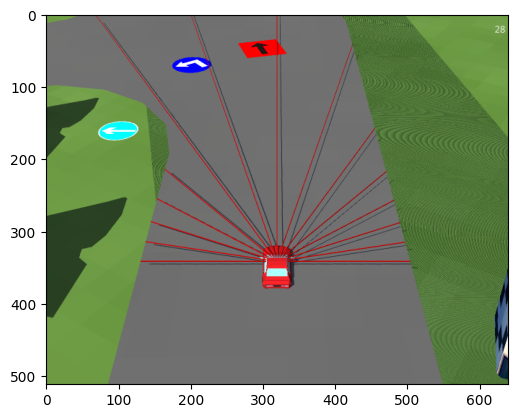

In [9]:
data_images=[]
data_labels=[]
data_colors=[]

#for each record we're going to create a list of snapshots 
for record in glob.glob("*.npz"):   
    try:
        with lzma.open(record, "rb") as file:
            data = pickle.load(file)
            print("Read", len(data), "snapshots")
            # take color from number of file in record_colors
            color = record_colors[int(record.replace('.npz', '').split('_')[1])]
            #normalize color value RGB
            color = [c / 255 for c in color]
            #  for each snapshot we're goint to have the image, the controls on that image and the color of that snapshot, each record will have always th same colors
            for snapshot in data:
                data_images.append(snapshot.image)
                data_labels.append(snapshot.current_controls)
                data_colors.append(color)
    except EOFError:
        print("Error: Compressed file ended before the end-of-stream marker was reached.")
    except Exception as e:
        print(f"An error occurred: {e}")

#check type of image
print(type(data_images[0]))

#display image from numpy array
plt.imshow(data_images[0])

In [5]:
"""
# augment the data keeping the color just fliping the image and flipping left to right 
#front,back,left, right fot the commands

data_images_augmented = []
data_labels_augmented = []
data_colors_augmented = []

for image, label, color in zip(data_images, data_labels, data_colors):
    data_images_augmented.append(image)
    data_labels_augmented.append(label)
    data_colors_augmented.append(color)
    data_images_augmented.append(np.flip(image, axis=1))
    #flip the commands
    data_labels_augmented.append([label[0], label[1], label[2], label[3]])
    data_colors_augmented.append(color)

#concaten to the original data
data_images = np.concatenate([data_images, data_images_augmented])
data_labels = np.concatenate([data_labels, data_labels_augmented])
data_colors = np.concatenate([data_colors, data_colors_augmented])
"""

'\n# augment the data keeping the color just fliping the image and flipping left to right \n#front,back,left, right fot the commands\n\ndata_images_augmented = []\ndata_labels_augmented = []\ndata_colors_augmented = []\n\nfor image, label, color in zip(data_images, data_labels, data_colors):\n    data_images_augmented.append(image)\n    data_labels_augmented.append(label)\n    data_colors_augmented.append(color)\n    data_images_augmented.append(np.flip(image, axis=1))\n    #flip the commands\n    data_labels_augmented.append([label[0], label[1], label[2], label[3]])\n    data_colors_augmented.append(color)\n\n#concaten to the original data\ndata_images = np.concatenate([data_images, data_images_augmented])\ndata_labels = np.concatenate([data_labels, data_labels_augmented])\ndata_colors = np.concatenate([data_colors, data_colors_augmented])\n'

In [6]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.flatten_size = 32 * 128 * 160  # Update this based on actual output after layer2
        self.fc = nn.Linear(self.flatten_size, num_classes)  # Use calculated flatten size
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten the output
        out = self.fc(out)
        return out

# Define the second CNN for colors
class CNNColor(nn.Module):
    def __init__(self, num_classes):
        super(CNNColor, self).__init__()
        self.fc = nn.Linear(3, num_classes)
        
    def forward(self, x):
        out = self.fc(x)
        return out

class ConcatModel(nn.Module):
    def __init__(self, cnn, cnn_color):
        super(ConcatModel, self).__init__()
        self.cnn = cnn
        self.cnn_color = cnn_color
        # Update output dimension of the final layer to match the labels' dimension (4)
        self.fc = nn.Linear(cnn.fc.out_features + cnn_color.fc.out_features, 4)
        
    def forward(self, x, y):
        x = self.cnn(x)  # Output from image CNN
        y = self.cnn_color(y)  # Output from color CNN
        z = torch.cat((x, y), 1)  # Concatenate along the feature dimension
        z = self.fc(z)  # Final output with 4 dimensions
        return z

In [7]:
#Split the data into training and testing
X_train, X_test, y_train, y_test, color_train, color_test = train_test_split(data_images, data_labels, data_colors, test_size=0.2, random_state=42)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
#Transform the data into tensors making batches
class CustomDataset(Dataset):
    def __init__(self, X, y, c):
        # Convert images to tensor and permute dimensions to match [channels, height, width]
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.c = torch.tensor(c, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.c[idx]
    

train_dataset = CustomDataset(X_train, y_train, color_train)

In [ ]:
#Initiate the dataloader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
#Initiate the model
model = ConcatModel(CNN(2), CNNColor(2)).to(device)

In [ ]:
#Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/10], Loss: 1.1902025157007678
Epoch [1/10], Loss: 372707.60399561917
Epoch [1/10], Loss: 382196.22684044676
Epoch [1/10], Loss: 391550.4660645847
Epoch [1/10], Loss: 416495.2936507916
Epoch [1/10], Loss: 436368.85399561917
Epoch [1/10], Loss: 448050.295805964
Epoch [1/10], Loss: 451215.63632320537
Epoch [1/10], Loss: 451725.39891749417
Epoch [1/10], Loss: 451726.7156841673
Epoch [1/10], Loss: 451726.7582275662
Epoch [1/10], Loss: 451726.77836499544
Epoch [1/10], Loss: 451726.7945997633
Epoch [1/10], Loss: 451726.8092962678
Epoch [1/10], Loss: 451726.8255999304
Epoch [1/10], Loss: 451726.8420858167
Epoch [1/10], Loss: 451726.85915018566
Epoch [1/10], Loss: 451726.8742199437
Epoch [1/10], Loss: 451726.89035171375
Epoch [1/10], Loss: 451726.90820758406
Epoch [1/10], Loss: 451726.92467764637
Epoch [1/10], Loss: 451726.9444065803
Epoch [1/10], Loss: 451726.9606952462
Epoch [1/10], Loss: 451726.9806006222
Epoch [1/10], Loss: 451726.9982131699
Epoch [1/10], Loss: 451727.0161248487
Ep

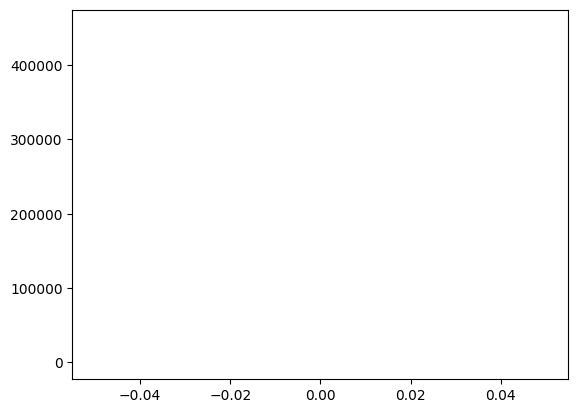

In [ ]:
# Assuming train_loader is defined
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels, colors = data
        inputs, labels, colors = inputs.to(device), labels.to(device), colors.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, colors)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")
        #plot the loss
        plt.plot(running_loss/len(train_loader))

In [ ]:
# Save the model
torch.save(model.state_dict(), "model.pth")